In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# 0. Folder creation

In [2]:
%%bash
# bash scrpting cell inside Jupyter
# structured mesh should be located on str_uns/structuredMesh 

# if the directory doesn't exists, create it
if [ ! -d "./str_uns" ]; then
  mkdir str_uns
fi

# ensure that the structured mesh exists
if [ ! -d "./str_uns/structuredMesh" ]; then
    echo "NON STRUCTURED MESH to convert"
    exit 0
fi

# remove the directory of a previously unstructured mesh
if [ -d "./str_uns/unstructuredMesh" ]; then
    rm str_uns/unstructuredMesh -r
    cp str_uns/structuredMesh str_uns/unstructuredMesh -r
fi

# or create the directory if it doesn't exist
if [ ! -d "str_uns/unstructuredMesh" ]; then
  cp str_uns/structuredMesh str_uns/unstructuredMesh -r
fi

# 1. Data input - point adquisition

In [3]:
# import the points file from the structured mesh
filename = './str_uns/structuredMesh/constant/polyMesh/points'
file = open(filename, "r")
points_str = file.read()

# go back two spaces in the file ('\n')
i = 2

# variable to store the number of points
pointsNo = 0

# go from  the first parenthesis backwards
while points_str[points_str.find('(')-i] != '\n':
    # if the spaces to go backwards are just two
    if i == 2:
        # just take the number
        pointsNo = int(points_str[points_str.find('(')-i])
    # if the spaces to go backwards are more than two
    else:
        # take the number of points and add the new number times 10**(i-2)
        pointsNo = pointsNo + int(points_str[points_str.find('(')-i]) * 10**(i-2)
    # go backwards another position
    i += 1
    
# preallocate space for the points
points = np.zeros((pointsNo, 3))

In [4]:
arrayPos = 0
tempPos = 0
negVal = 0
decimal = 0
engExp = 0

for i in range(points_str.find('(')+1, len(points_str)):
    #First element of each line resets the temporal points
    if points_str[i] == '(':
        tempPoints = np.zeros(3)
    #End element of each line transfer the elements to the big array, resets tempPos and advance 1 in arrayPos
    elif points_str[i] == ')':
        points[arrayPos,:] = tempPoints
        arrayPos += 1
        tempPos = 0
    #An space will do nothing for the moment!
    elif points_str[i] == ' ' :
        pass;
    #New line will do nothing! - except if it arrives to the end of the string it will encounter ) \n ) 
    elif points_str[i] == '\n':
        if points_str[i-1] == ')' and points_str[i] == '\n' and points_str[i+1] == ')':
            break;
    #Minus sign will do nothing (for the moment!)
    elif points_str[i] == '-':
        if engExp == 0:
            negVal = 1
    #Period will do nothing (for the moment!)
    elif points_str[i] == '.':
        decimal = 1;
    #Engineering notation
    elif points_str[i] == 'e':
        if points_str[i+1] == '-':
            engExp = - (10 * int(points_str[i+2]) + int(points_str[i+3]))
        else:
            engExp = (10 * int(points_str[i+2]) + int(points_str[i+3]))
    #If the element is a number...
    else:
        if engExp == 0:            
            #if it is zero we are still on the natural part of the number
            if decimal == 0:    
                tempPoints[tempPos] = 10*tempPoints[tempPos]+int(points_str[i])
            #if the decimal variable is not zero
            if decimal >= 1:
                #If the next element of the string is a space or a ), the number will be completed
                if points_str[i+1] == ' ' or points_str[i+1] == ')':
                    tempPoints[tempPos] = tempPoints[tempPos]+int(points_str[i])*10**(-decimal)
                    decimal = 0
                #If it is a number
                else: 
                    tempPoints[tempPos] = tempPoints[tempPos]+int(points_str[i])*10**(-decimal)
                    decimal += 1
            #If the next element is a space...
            if points_str[i+1] == ' ' :
                #... and a negative sign was found, it should multiply now by -1 and advance one position...
                if negVal == 1:
                    tempPoints[tempPos] *= -1
                    tempPos += 1
                    negVal = 0
                #... otherwise it will just advance one position
                else:
                    tempPos += 1
        else:
            if points_str[i+1] == ' ' :
                #... and a negative sign was found, it should multiply now by -1 and advance one position...
                if negVal == 1:
                    tempPoints[tempPos] *= -1*10**(engExp)
                    tempPos += 1
                    negVal = 0
                    engExp = 0
                #... otherwise it will just advance one position
                else:
                    tempPoints[tempPos] *= -1*10**(engExp)
                    tempPos += 1 
                    engExp = 0

# 2. Grid conversion

Select the bounding box within the unstructured grid will be computed. There are two options for selecting where the operation will be performed:
* The whole range of the grid is selected
* The range is specified with two values

One of the two options must be selected for every axis.

In [5]:
# get the maximum and minimum (if the whole axis grids is selected)
# Xmax = np.max(points[:,0])
# Xmin = np.min(points[:,0])
Ymax = np.max(points[:,1])
Ymin = np.min(points[:,1])
Zmax = np.max(points[:,2])
Zmin = np.min(points[:,2])

# specify the ranges (if not the whole grid is selected)
Xmax = 10
Xmin = 1
# Ymax = 
# Ymin = 
# Zmax = 
# Zmin = 

In [6]:
# distance factor to restrict the maximum displacement of the points
# tune up the value according to the size of the cells
k = 0.05

In [7]:
# copy the points for the unstructured grid 
unstrPoints = np.copy(points)

# boolean matrix for the minimum z-coordinate plane
frontPoints = points[:,2] == Zmin

# boolean matrix for the maximum z-coordinate plane
backPoints = points[:,2] == Zmax

# the size of the front and back plane should be the same
if np.shape(points[frontPoints,:]) != np.shape(points[backPoints,:]):
    raise ValueError('Front and back plane does not have the same size')

In [8]:
# slightly perturb the points of the structured mesh to get the unstructured
for i in np.nditer(np.where(frontPoints)):
    # if the point is within bounds
    if Xmax > points[i,0] > Xmin and Ymax > points[i,1] > Ymin:
        # compute the distance from every point to i-th point
        # retain just the 8 closest (4 front plane & 4 back plane)
        # neglecting the same point and its projection (going from 2 to 10)
        vec = np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[2:10]
        # obtain the backPlane point which corresponds to the i-th point
        if np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[1] == i:
            backPoint = np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[0]  
        else:
            backPoint = np.sqrt((points[:,0]-points[i,0])**2+(points[:,1]-points[i,1])**2).argsort()[1]
        # separate them between front and back plane
        frontVec = vec[points[vec,2] == Zmin]
        # a estimation of the zone in which the i-th point can move are
        maxX = max(points[frontVec,0])
        maxY = max(points[frontVec,1])
        minX = min(points[frontVec,0])
        minY = min(points[frontVec,1])
        # compute the variation in both x and y components
        varX = np.random.normal(0, k*abs(minX-maxX))
        varY = np.random.normal(0, k*abs(minY-maxY))
        # store the point with the perturbation in the new array
        unstrPoints[i,0] = points[i,0]+varX
        unstrPoints[i,1] = points[i,1]+varY
        unstrPoints[backPoint,0] = points[backPoint,0]+varX
        unstrPoints[backPoint,1] = points[backPoint,1]+varY

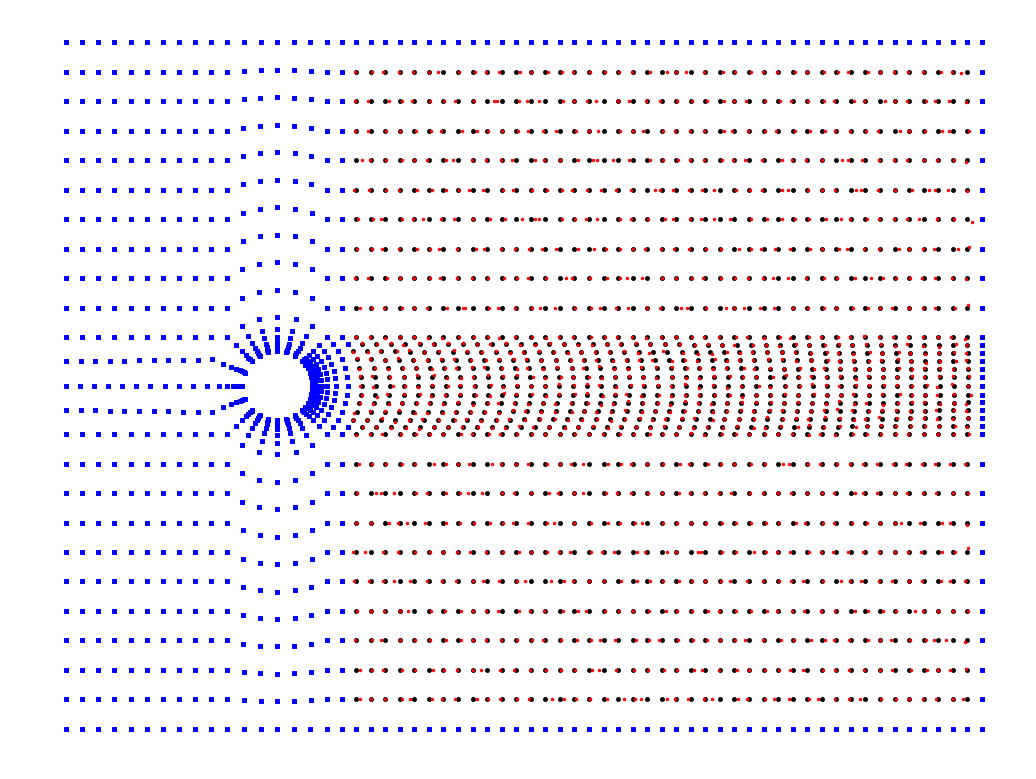

In [9]:
fig, ax1 = plt.subplots(1, figsize=(26,20), dpi = 50)

# go through all points in the front plane
for i in np.nditer(np.where(frontPoints)):
    # location of the older points
    if Xmax > points[i,0] > Xmin and Ymax > points[i,1] > Ymin:
        ax1.plot(points[i,0], points[i,1], 'ko', markersize=6)
    # unperturbed points
    else:
        ax1.plot(points[i,0], points[i,1], 'bs')
    # new location of the perturbed points
    if Xmax > unstrPoints[i,0] > Xmin and Ymax > unstrPoints[i,1] > Ymin:
        ax1.plot(unstrPoints[i,0], unstrPoints[i,1], 'ro', markersize=4)
    # just to make sure that points that are out bounds haven't been perturbed
    else:
        ax1.plot(unstrPoints[i,0], unstrPoints[i,1], 'bs')
# hide axis for aesthetic reasons
ax1.axis('off');

# 3. Point saving

In [10]:
%%bash
# delete the points file of the unstructured mesh
rm ./str_uns/unstructuredMesh/constant/polyMesh/points

In [11]:
# store the new points in the corresponding file
with open('./str_uns/unstructuredMesh/constant/polyMesh/points', 'a') as uPF: 
    # uPF stands for unstructuredPointFile
    uPF.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    uPF.write('| =========                 |                                                 | \n')
    uPF.write('| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    uPF.write('|  \\    /   O peration     | Version:  5.x                                   | \n')
    uPF.write('|   \\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    uPF.write('|    \\/     M anipulation  |                                                 | \n')
    uPF.write('\*---------------------------------------------------------------------------*/ \n')
    uPF.write('FoamFile \n')
    uPF.write('{ \n')
    uPF.write('    version     2.0; \n')
    uPF.write('    format      ascii; \n')
    uPF.write('    class       vectorField; \n')
    uPF.write('    location    "constant/polyMesh"; \n')
    uPF.write('    object      points; \n')
    uPF.write('} \n')
    uPF.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * // \n')
    uPF.write('\n')
    uPF.write('%i \n' %(pointsNo))
    uPF.write('(')
    for i in range(pointsNo):
        uPF.write('(%.6f %.6f %.6f) \n' %(unstrPoints[i,0], unstrPoints[i,1], unstrPoints[i,2]))        
    uPF.write(')')

In [12]:
%%bash
# check the mesh and run paraFoam
cd str_uns/unstructuredMesh/
checkMesh > /dev/null
paraFoam

Created temporary 'unstructuredMesh.OpenFOAM'
I/O    : uncollated
